In [ ]:
from google.colab import drive
import os
import pandas as pd

ModuleNotFoundError: No module named 'google'

# Mounting the Drive

In [ ]:
drive.mount("/content/drive", force_remount=True)

path = "/content/drive/My Drive/PCAP Dataset/Copy of packets_raw.csv"

df = pd.read_csv(path, sep=',', on_bad_lines='skip', engine='python')

Mounted at /content/drive


# RAW VERSION OF THE DATASET

In [ ]:
df.head()

,frame.time_epoch,frame.len,ip.src,ip.dst,ip.proto,tcp.srcport,tcp.dstport,udp.srcport,udp.dstport
0,1.744194e+09,60.0,203.178.162.159,95.147.81.104,1.0,NaN,NaN,NaN,NaN
1,1.744194e+09,1324.0,NaN,NaN,NaN,52278.0,443.0,NaN,NaN
2,1.744194e+09,60.0,203.178.162.159,38.209.248.201,1.0,NaN,NaN,NaN,NaN
3,1.744194e+09,74.0,199.219.149.64,210.34.198.238,6.0,25188.0,1080.0,NaN,NaN
4,1.744194e+09,74.0,162.70.131.74,150.67.151.48,6.0,55292.0,8085.0,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11762985 entries, 0 to 11762984
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   frame.time_epoch  float64
 1   frame.len         float64
 2   ip.src            object 
 3   ip.dst            object 
 4   ip.proto          float64
 5   tcp.srcport       float64
 6   tcp.dstport       float64
 7   udp.srcport       float64
 8   udp.dstport       float64
dtypes: float64(7), object(2)
memory usage: 807.7+ MB


# Managing Null Values

In [ ]:
# We are dropping values that has null on IP Proto because we are keeping our dataset above the IP(this is where the user activity manifests)
df = df.dropna(subset=["ip.proto"])

# Keeping protocols separate is not reliable to distinguish user activity anymore in the modern web. That's why we have combine them
df["src_port"] = df["tcp.srcport"].fillna(df["udp.srcport"])
df["dst_port"] = df["tcp.dstport"].fillna(df["udp.dstport"])

# Drop data points that has no port because it will have noise
df = df.dropna(subset=["src_port", "dst_port"])





/tmp/ipython-input-3897254027.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["src_port"] = df["tcp.srcport"].fillna(df["udp.srcport"])
/tmp/ipython-input-3897254027.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dst_port"] = df["tcp.dstport"].fillna(df["udp.dstport"])


In [ ]:
df["flow_id"] = (
    df["ip.src"] + "-" +
    df["ip.dst"] + "-" +
    df["src_port"].astype(str) + "-" +
    df["dst_port"].astype(str) + "-" +
    df["ip.proto"].astype(str)
)

In [ ]:
df.head()

,frame.time_epoch,frame.len,ip.src,ip.dst,ip.proto,tcp.srcport,tcp.dstport,udp.srcport,udp.dstport,src_port,dst_port,flow_id
3,1.744194e+09,74.0,199.219.149.64,210.34.198.238,6.0,25188.0,1080.0,NaN,NaN,25188.0,1080.0,199.219.149.64-210.34.198.238-25188.0-1080.0-6.0
4,1.744194e+09,74.0,162.70.131.74,150.67.151.48,6.0,55292.0,8085.0,NaN,NaN,55292.0,8085.0,162.70.131.74-150.67.151.48-55292.0-8085.0-6.0
7,1.744194e+09,66.0,172.219.225.42,131.113.151.154,6.0,443.0,48565.0,NaN,NaN,443.0,48565.0,172.219.225.42-131.113.151.154-443.0-48565.0-6.0
9,1.744194e+09,78.0,150.67.111.120,143.245.10.217,17.0,NaN,NaN,65150.0,34586.0,65150.0,34586.0,150.67.111.120-143.245.10.217-65150.0-34586.0-...
10,1.744194e+09,66.0,195.47.191.192,203.178.179.153,6.0,59608.0,830.0,NaN,NaN,59608.0,830.0,195.47.191.192-203.178.179.153-59608.0-830.0-6.0


In [ ]:
flows = df.groupby("flow_id").agg(
    packet_count=("frame.len", "count"),
    byte_count=("frame.len", "sum"),
    avg_pkt_len=("frame.len", "mean"),
    std_pkt_len=("frame.len", "std"),
    start_time=("frame.time_epoch", "min"),
    end_time=("frame.time_epoch", "max"),
)
flows["flow_duration"] = flows["end_time"] - flows["start_time"]

In [ ]:
flows.head()

,packet_count,byte_count,avg_pkt_len,std_pkt_len,start_time,end_time,flow_duration
flow_id,,,,,,,
1.1.7.24-202.24.162.124-45888.0-23.0-6.0,9,506.0,56.222222,6.666667,1.744194e+09,1.744194e+09,35.942059
1.108.145.110-133.15.123.54-55106.0-4343.0-6.0,5,330.0,66.000000,0.000000,1.744194e+09,1.744194e+09,15.045203
1.108.186.229-131.113.191.161-61153.0-443.0-6.0,9,2738.0,304.222222,438.458316,1.744194e+09,1.744194e+09,1.258956
1.11.42.26-202.152.241.42-61516.0-11194.0-17.0,9,2096.0,232.888889,154.320644,1.744194e+09,1.744194e+09,51.536455
1.111.109.212-131.112.204.247-36373.0-993.0-6.0,5,429.0,85.800000,28.110496,1.744194e+09,1.744194e+09,0.134992


In [ ]:
flows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98380 entries, 1.1.7.24-202.24.162.124-45888.0-23.0-6.0 to 99.86.92.118-203.178.190.20-443.0-15900.0-6.0
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   packet_count   98380 non-null  int64  
 1   byte_count     98380 non-null  float64
 2   avg_pkt_len    98380 non-null  float64
 3   std_pkt_len    98380 non-null  float64
 4   start_time     98380 non-null  float64
 5   end_time       98380 non-null  float64
 6   flow_duration  98380 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 8.0+ MB


In [ ]:
flows = flows[
    (flows["packet_count"] >= 5) &
    (flows["flow_duration"] > 0) &
    (flows["packet_count"] <= 2000)
]

In [ ]:
flows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98380 entries, 1.1.7.24-202.24.162.124-45888.0-23.0-6.0 to 99.86.92.118-203.178.190.20-443.0-15900.0-6.0
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   packet_count   98380 non-null  int64  
 1   byte_count     98380 non-null  float64
 2   avg_pkt_len    98380 non-null  float64
 3   std_pkt_len    98380 non-null  float64
 4   start_time     98380 non-null  float64
 5   end_time       98380 non-null  float64
 6   flow_duration  98380 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 6.0+ MB


In [ ]:
flows = flows.reset_index()
flows.rename(columns={"index": "flow_id"}, inplace=True)

flows[["ip_src", "ip_dst", "src_port", "dst_port", "ip_proto"]] = flows["flow_id"].str.split("-", expand=True)

flows["src_port"] = flows["src_port"].astype(float)
flows["dst_port"] = flows["dst_port"].astype(float)
flows["ip_proto"] = flows['ip_proto'].astype(float)

In [ ]:
flows.head()

,flow_id,packet_count,byte_count,avg_pkt_len,std_pkt_len,start_time,end_time,flow_duration,ip_src,ip_dst,src_port,dst_port,ip_proto
0,1.1.7.24-202.24.162.124-45888.0-23.0-6.0,9,506.0,56.222222,6.666667,1.744194e+09,1.744194e+09,35.942059,1.1.7.24,202.24.162.124,45888.0,23.0,6.0
1,1.108.145.110-133.15.123.54-55106.0-4343.0-6.0,5,330.0,66.000000,0.000000,1.744194e+09,1.744194e+09,15.045203,1.108.145.110,133.15.123.54,55106.0,4343.0,6.0
2,1.108.186.229-131.113.191.161-61153.0-443.0-6.0,9,2738.0,304.222222,438.458316,1.744194e+09,1.744194e+09,1.258956,1.108.186.229,131.113.191.161,61153.0,443.0,6.0
3,1.11.42.26-202.152.241.42-61516.0-11194.0-17.0,9,2096.0,232.888889,154.320644,1.744194e+09,1.744194e+09,51.536455,1.11.42.26,202.152.241.42,61516.0,11194.0,17.0
4,1.111.109.212-131.112.204.247-36373.0-993.0-6.0,5,429.0,85.800000,28.110496,1.744194e+09,1.744194e+09,0.134992,1.111.109.212,131.112.204.247,36373.0,993.0,6.0


In [ ]:
flows = flows.drop("flow_id", axis=1)

In [ ]:
flows_sampled = flows.groupby("ip_proto").apply(lambda x: x.sample(min(len(x),1000), random_state=42)).reset_index(drop=True)

/tmp/ipython-input-389900853.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flows_sampled = flows.groupby("ip_proto").apply(lambda x: x.sample(min(len(x),2500), random_state=42)).reset_index(drop=True)


In [ ]:
flows_sampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   packet_count   5000 non-null   int64  
 1   byte_count     5000 non-null   float64
 2   avg_pkt_len    5000 non-null   float64
 3   std_pkt_len    5000 non-null   float64
 4   start_time     5000 non-null   float64
 5   end_time       5000 non-null   float64
 6   flow_duration  5000 non-null   float64
 7   ip_src         5000 non-null   object 
 8   ip_dst         5000 non-null   object 
 9   src_port       5000 non-null   float64
 10  dst_port       5000 non-null   float64
 11  ip_proto       5000 non-null   float64
dtypes: float64(9), int64(1), object(2)
memory usage: 468.9+ KB


# FEATURE ENGINEERING

**Reasoning**:
The subtask requires selecting specific numerical features, then scaling them using `StandardScaler` to prepare for clustering. I will define the list of features, select them from the `flows_sampled` DataFrame, import `StandardScaler`, initialize it, and then apply `fit_transform` to scale the features.



In [ ]:
from sklearn.preprocessing import StandardScaler

features_for_clustering = [
    "packet_count",
    "byte_count",
    "avg_pkt_len",
    "std_pkt_len",
    "flow_duration",
    "src_port",
    "dst_port"
]

X = flows_sampled[features_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape of X_scaled:", X_scaled.shape)
print("First 5 rows of X_scaled:\n", X_scaled[:5])

Shape of X_scaled: (5000, 7)
First 5 rows of X_scaled:
 [[-0.22835758 -0.09503012 -0.50318363 -0.54779131 -0.47907045  0.71370943
   1.13161486]
 [-0.22835758 -0.09366794 -0.40361176 -0.34530883  0.01832898  1.47275954
  -0.96921426]
 [-0.19251789 -0.05211632  1.14975     2.31673948 -0.72869462 -1.09939018
   0.94735864]
 [-0.23552551 -0.09479123 -0.45666722 -0.51524874 -0.79230202  0.98897816
  -0.98462493]
 [-0.19968583 -0.08693327 -0.19919219 -0.00277115 -0.67664189 -0.98148648
  -0.38108011]]


## Determine Optimal Number of Clusters

### Subtask:
Use the Elbow Method to determine an optimal number of clusters for K-Means. This will involve plotting the inertia for a range of K values.


**Reasoning**:
To determine the optimal number of clusters using the Elbow Method, I will import `KMeans` and `matplotlib.pyplot`, then iterate through a range of K values, fit a KMeans model for each, record its inertia, and finally plot the inertia against K values.



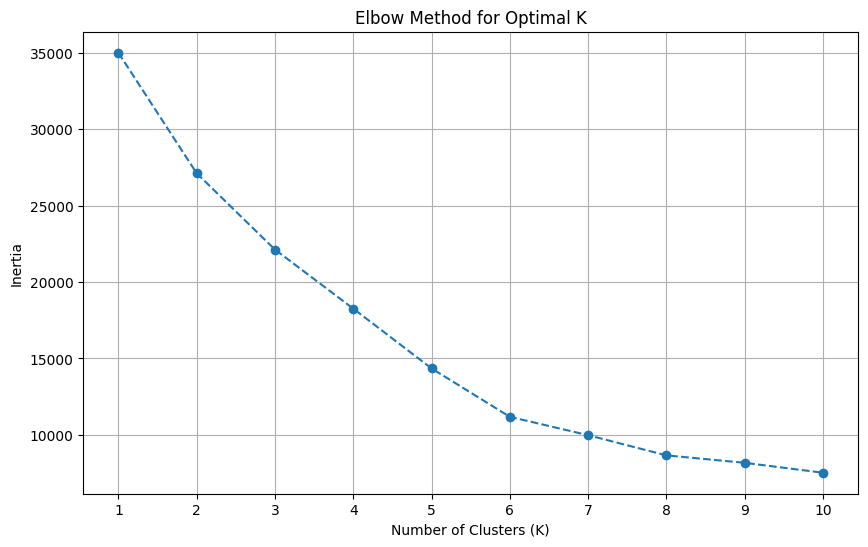

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

# Try K values from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

### Interpreting the Elbow Plot

The Elbow Method plot shows the inertia (within-cluster sum of squares) as a function of the number of clusters (K).

To find the optimal K:
1. **Look for the 'elbow'**: The elbow point is where the rate of decrease in inertia sharply changes, forming an 'elbow' in the plot. Beyond this point, adding more clusters does not significantly reduce the inertia.
2. **Common choices**: In many cases, K=3 or K=4 might be considered as potential elbow points, where the curve starts to flatten out. For this specific plot, a good candidate for the elbow appears to be around K=3 or K=4, as the decrease in inertia becomes less substantial after these points.

## Apply K-Means Clustering

### Subtask:
Apply the K-Means clustering algorithm to the prepared data with the chosen number of clusters and add the cluster labels back to the dataframe.


**Reasoning**:
To apply K-Means clustering, I will first instantiate the KMeans model with the specified parameters, then fit it to the scaled data, predict the cluster labels, and finally add these labels as a new column to the original sampled DataFrame.



In [ ]:
kmeans_model = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_model.fit(X_scaled)

flows_sampled['cluster_label'] = kmeans_model.predict(X_scaled)

print("First 5 rows of flows_sampled with cluster labels:")
print(flows_sampled.head())

First 5 rows of flows_sampled with cluster labels:
   packet_count  byte_count  avg_pkt_len  std_pkt_len    start_time  \
0             6       344.0    57.333333     8.164966  1.744194e+09   
1             6       612.0   102.000000   100.901933  1.744194e+09   
2            11      8787.0   798.818182  1320.119905  1.744194e+09   
3             5       391.0    78.200000    23.069460  1.744194e+09   
4            10      1937.0   193.700000   257.784169  1.744194e+09   

       end_time  flow_duration           ip_src          ip_dst  src_port  \
0  1.744194e+09       7.471334   167.89.182.126  202.24.165.141   45746.0   
1  1.744194e+09      18.579121  163.164.144.165   104.45.240.24   64712.0   
2  1.744194e+09       1.896796  161.117.139.230  150.67.110.222     443.0   
3  1.744194e+09       0.476333     51.217.99.57  203.178.181.27   52624.0   
4  1.744194e+09       3.059223   133.28.231.176   91.249.139.99    3389.0   

   dst_port  ip_proto  cluster_label  
0   53609.0       6.

## Dimensionality Reduction for Visualization

### Subtask:
Apply Principal Component Analysis (PCA) to reduce the clustered data to 2 components for effective visualization.


**Reasoning**:
To apply PCA, I will import the PCA class, instantiate it with 2 components and a random state, and then fit and transform the scaled data.



In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_scaled)

print("Shape of PCA components:", pca_components.shape)
print("First 5 rows of PCA components:\n", pca_components[:5])

Shape of PCA components: (5000, 2)
First 5 rows of PCA components:
 [[-0.49792788 -0.51113648]
 [-1.31847025  0.93476989]
 [ 2.57196603 -1.09660538]
 [-1.21898835  0.51894375]
 [ 0.09067487 -0.61307519]]


## Visualize Clusters

### Subtask:
Create a scatter plot of the two principal components, colored by the assigned cluster labels, to visualize the clustering results. Make sure to add a legend.


**Reasoning**:
To visualize the clustering results, I will create a scatter plot of the two principal components, coloring the points by their assigned cluster labels, and add appropriate labels, title, and a legend for clarity.



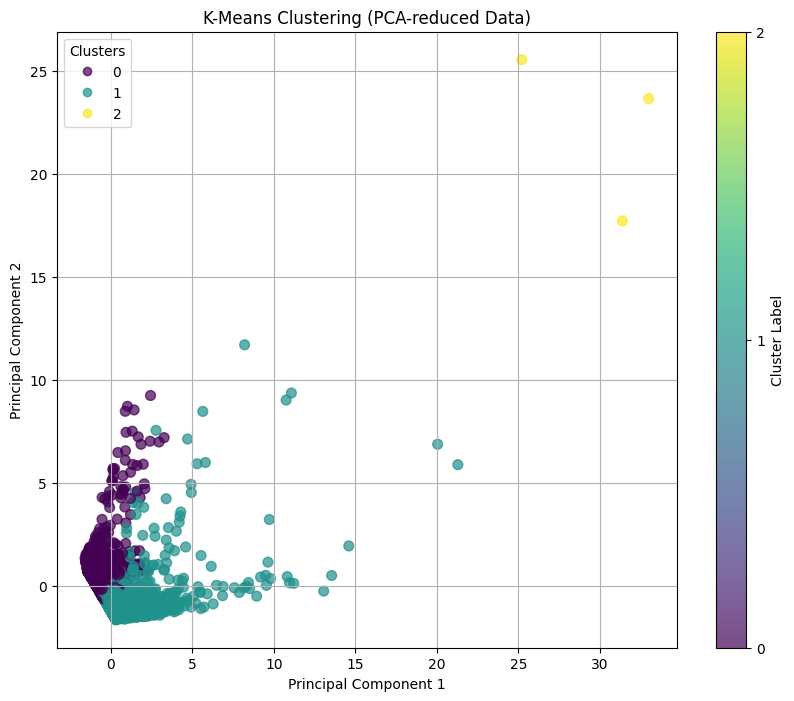

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=flows_sampled['cluster_label'], cmap='viridis', s=50, alpha=0.7)
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label', ticks=flows_sampled['cluster_label'].unique())
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.grid(True)
plt.show()

## Final Task

### Subtask:
Summarize the clustering process, the chosen number of clusters, and any insights gained from the visualization of the clustered data.


## Summary:

### Data Analysis Key Findings

*   **Feature Selection and Scaling**: Seven numerical features (`packet_count`, `byte_count`, `avg_pkt_len`, `std_pkt_len`, `flow_duration`, `src_port`, `dst_port`) were selected from the `flows_sampled` DataFrame and successfully scaled using `StandardScaler`. The resulting scaled data (`X_scaled`) has a shape of (5000, 7).
*   **Optimal Number of Clusters**: The Elbow Method was applied by plotting the inertia for K values from 1 to 10. Based on the elbow plot, the optimal number of clusters was identified as K=3 or K=4, as the decrease in inertia became less substantial after these points.
*   **K-Means Clustering Application**: K-Means clustering was performed with 3 clusters (`n_clusters=3`), as suggested by the Elbow Method. The resulting cluster labels were successfully added as a new column, `cluster_label`, to the `flows_sampled` DataFrame.
*   **Dimensionality Reduction for Visualization**: Principal Component Analysis (PCA) was applied to the scaled features, reducing their dimensionality to 2 components (`pca_components`). This reduction resulted in data with a shape of (5000, 2), suitable for 2D visualization.
*   **Clustering Visualization**: A scatter plot was generated using the two principal components, with points colored according to their assigned K-Means cluster labels. The plot clearly visualizes the separation and distribution of the three clusters in a 2-dimensional space, including a title, axis labels, a colorbar, and a legend for clarity.

### Insights or Next Steps

*   The visualization effectively presents the spatial relationship between the identified clusters, allowing for a qualitative assessment of their distinctiveness and potential overlap in the reduced 2D space.
*   Further analysis could involve examining the characteristics (e.g., mean values of original features) of each cluster to understand what differentiates them, which could reveal different types of network flow behaviors.


# Task
Apply DBSCAN clustering to the `X_scaled` data, tune the parameters `eps` and `min_samples` for effective cluster identification, visualize the resulting clusters using PCA-reduced components, and then add the DBSCAN cluster labels to the `flows_sampled` DataFrame.

## DBSCAN Clustering

### Subtask:
Apply DBSCAN clustering to the scaled data, focusing on parameter tuning (epsilon and min_samples) and then visualize the clusters using PCA-reduced components. The cluster labels will be added to the `flows_sampled` DataFrame.


**Reasoning**:
To begin DBSCAN clustering, I need to import the necessary classes: `DBSCAN` for the clustering algorithm and `NearestNeighbors` to help determine the optimal `eps` parameter. Following the instructions, I will also prepare for the `eps` tuning by calculating distances to the k-th nearest neighbors.



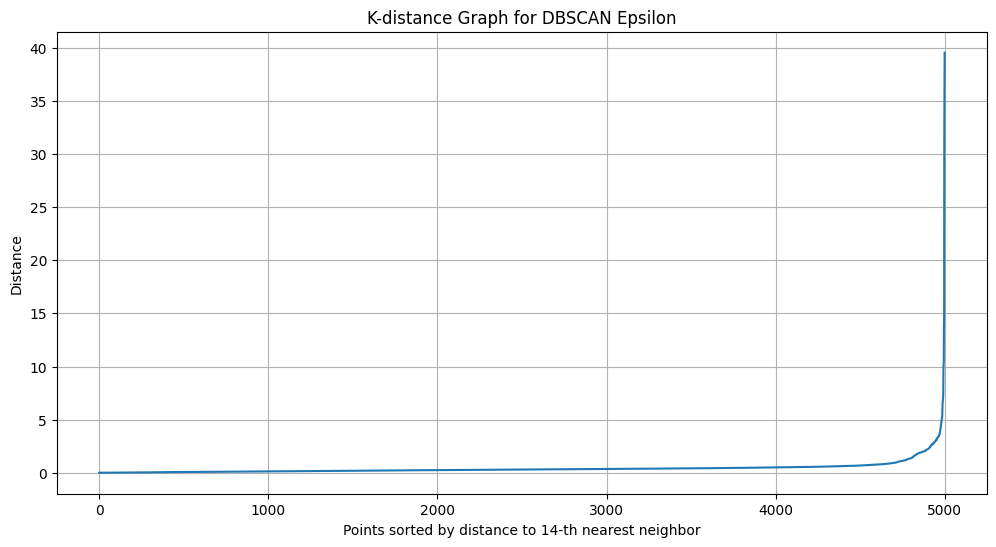

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Determine k for NearestNeighbors (2 * number of features)
k = 2 * X_scaled.shape[1] # X_scaled has 7 features, so k = 14

# Calculate the distance to the k-th nearest neighbor for each point
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_scaled)
distances, indices = neigh.kneighbors(X_scaled)

# Sort distances and plot to find the elbow point for eps
distances = np.sort(distances[:, k-1], axis=0)

plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title('K-distance Graph for DBSCAN Epsilon')
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
plt.ylabel('Distance')
plt.grid(True)
plt.show()

**Reasoning**:
Based on the k-distance graph, I will select an appropriate `eps` value, then instantiate and apply the DBSCAN model to `X_scaled`, add the resulting cluster labels to `flows_sampled`, and finally visualize these clusters using the PCA-reduced components.



Number of DBSCAN clusters found (excluding noise): 1
Number of noise points (-1 label): 214


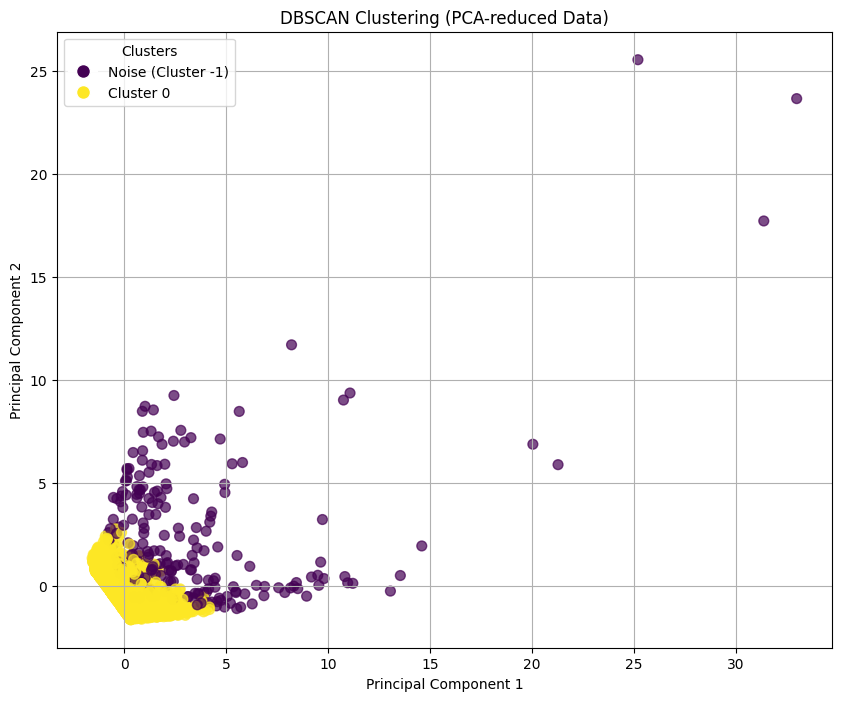

First 5 rows of flows_sampled with DBSCAN cluster labels:
   packet_count  byte_count  avg_pkt_len  std_pkt_len    start_time  \
0             6       344.0    57.333333     8.164966  1.744194e+09   
1             6       612.0   102.000000   100.901933  1.744194e+09   
2            11      8787.0   798.818182  1320.119905  1.744194e+09   
3             5       391.0    78.200000    23.069460  1.744194e+09   
4            10      1937.0   193.700000   257.784169  1.744194e+09   

       end_time  flow_duration           ip_src          ip_dst  src_port  \
0  1.744194e+09       7.471334   167.89.182.126  202.24.165.141   45746.0   
1  1.744194e+09      18.579121  163.164.144.165   104.45.240.24   64712.0   
2  1.744194e+09       1.896796  161.117.139.230  150.67.110.222     443.0   
3  1.744194e+09       0.476333     51.217.99.57  203.178.181.27   52624.0   
4  1.744194e+09       3.059223   133.28.231.176   91.249.139.99    3389.0   

   dst_port  ip_proto  cluster_label  dbscan_cluster

In [ ]:
dbscan = DBSCAN(eps=0.9, min_samples=k)
dbscan_cluster_labels = dbscan.fit_predict(X_scaled)

flows_sampled['dbscan_cluster_label'] = dbscan_cluster_labels

print("Number of DBSCAN clusters found (excluding noise):", len(np.unique(dbscan_cluster_labels[dbscan_cluster_labels != -1])))
print("Number of noise points (-1 label):", np.sum(dbscan_cluster_labels == -1))

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=flows_sampled['dbscan_cluster_label'], cmap='viridis', s=50, alpha=0.7)
plt.title('DBSCAN Clustering (PCA-reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create a legend for the clusters, handling noise points (-1 label)
legend_elements = []
unique_labels = np.unique(dbscan_cluster_labels)
for label in unique_labels:
    if label == -1:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Noise (Cluster -1)',
                                        markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10))
    else:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {label}',
                                        markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10))

plt.legend(handles=legend_elements, title='Clusters')
plt.grid(True)
plt.show()

print("First 5 rows of flows_sampled with DBSCAN cluster labels:")
print(flows_sampled.head())

## Gaussian Mixture Model (GMM) Clustering

### Subtask:
Apply Gaussian Mixture Model (GMM) clustering to the scaled data, determine the optimal number of components (if not already known), and then visualize the clusters using PCA-reduced components. The cluster labels will be added to the `flows_sampled` DataFrame.


**Reasoning**:
To apply GMM clustering and determine the optimal number of components, I will import the `GaussianMixture` class and initialize lists to store BIC and AIC scores. I will then iterate through a range of components, fit a GMM model for each, and record its BIC and AIC scores.



In [ ]:
from sklearn.mixture import GaussianMixture

bic = []
aic = []
n_components_range = range(1, 11)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    bic.append(gmm.bic(X_scaled))
    aic.append(gmm.aic(X_scaled))

print("BIC scores:", bic)
print("AIC scores:", aic)

BIC scores: [np.float64(85328.35377126123), np.float64(12899.391525425995), np.float64(10852.34840037206), np.float64(-11110.807708874998), np.float64(-20823.749248924665), np.float64(-22641.693373671118), np.float64(-29094.76623995675), np.float64(-41509.31705222809), np.float64(-34292.92878185478), np.float64(-45104.44040945901)]
AIC scores: [np.float64(85100.25200956166), np.float64(12436.670808835443), np.float64(10155.008728890523), np.float64(-12042.76633524752), np.float64(-21990.326830188173), np.float64(-24042.889909825608), np.float64(-30730.581731002225), np.float64(-43379.75149816455), np.float64(-36397.98218268223), np.float64(-47444.112765177444)]


**Reasoning**:
I will plot the calculated BIC and AIC scores against the number of components to visually identify the optimal number of clusters for GMM, as lower values indicate better models.



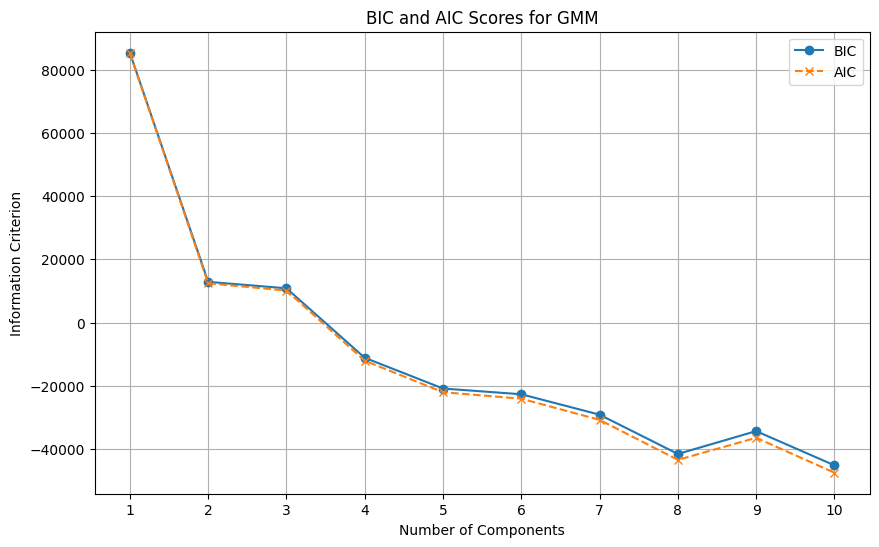

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic, marker='o', linestyle='-', label='BIC')
plt.plot(n_components_range, aic, marker='x', linestyle='--', label='AIC')
plt.title('BIC and AIC Scores for GMM')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
Based on the BIC and AIC scores, the optimal number of components appears to be 10, as it yields the lowest values for both criteria within the tested range. I will now apply GMM with this chosen number of components, predict the cluster labels, add them to the DataFrame, and then visualize these clusters using PCA-reduced components.



Number of GMM clusters found: 10
First 5 rows of flows_sampled with GMM cluster labels:
   packet_count  byte_count  avg_pkt_len  std_pkt_len    start_time  \
0             6       344.0    57.333333     8.164966  1.744194e+09   
1             6       612.0   102.000000   100.901933  1.744194e+09   
2            11      8787.0   798.818182  1320.119905  1.744194e+09   
3             5       391.0    78.200000    23.069460  1.744194e+09   
4            10      1937.0   193.700000   257.784169  1.744194e+09   

       end_time  flow_duration           ip_src          ip_dst  src_port  \
0  1.744194e+09       7.471334   167.89.182.126  202.24.165.141   45746.0   
1  1.744194e+09      18.579121  163.164.144.165   104.45.240.24   64712.0   
2  1.744194e+09       1.896796  161.117.139.230  150.67.110.222     443.0   
3  1.744194e+09       0.476333     51.217.99.57  203.178.181.27   52624.0   
4  1.744194e+09       3.059223   133.28.231.176   91.249.139.99    3389.0   

   dst_port  ip_proto 

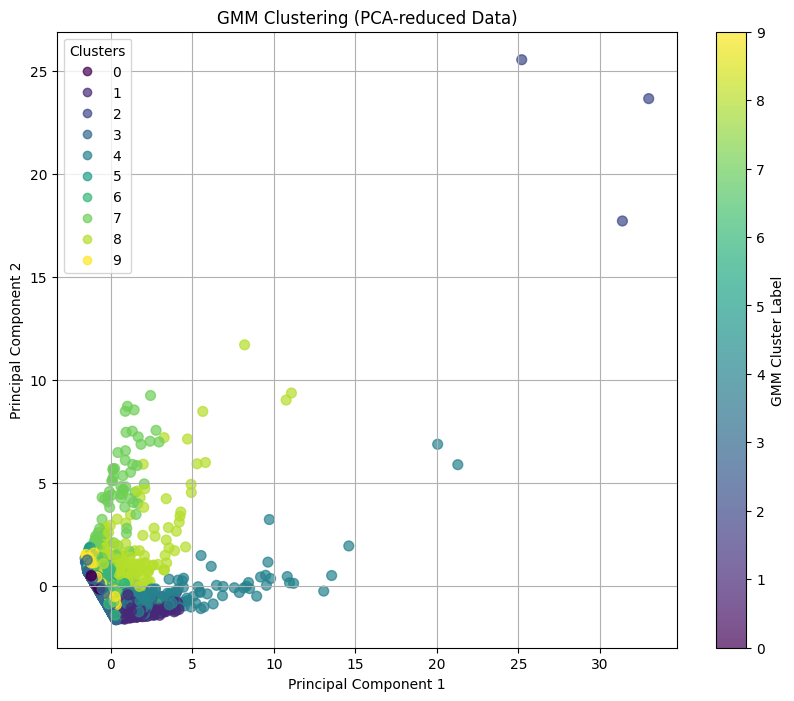

In [ ]:
optimal_n_components = 10 # Based on the lowest BIC/AIC scores from the plot

gmm_model = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm_model.fit(X_scaled)

flows_sampled['gmm_cluster_label'] = gmm_model.predict(X_scaled)

print(f"Number of GMM clusters found: {optimal_n_components}")
print("First 5 rows of flows_sampled with GMM cluster labels:")
print(flows_sampled.head())

# Visualize GMM clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=flows_sampled['gmm_cluster_label'], cmap='viridis', s=50, alpha=0.7)
plt.title('GMM Clustering (PCA-reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Create colorbar and legend
plt.colorbar(scatter, label='GMM Cluster Label', ticks=range(optimal_n_components))
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.grid(True)
plt.show()

## Summarize New Clustering Results

### Subtask:
Summarize the results of both DBSCAN and GMM clustering, including the chosen parameters, the number of clusters found, and any insights gained from their visualizations compared to K-Means.


## Summary:

### Data Analysis Key Findings

*   **DBSCAN Clustering**:
    *   The `min_samples` parameter was set to 14 (based on 2 * number of features).
    *   The `eps` parameter was chosen as 0.9 after generating a K-distance graph.
    *   DBSCAN identified 1 primary cluster and classified 214 points as noise.
    *   The visualization in the PCA-reduced space showed one main dense region with numerous dispersed noise points.
*   **Gaussian Mixture Model (GMM) Clustering**:
    *   The optimal number of components was determined to be 10, based on minimizing both BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion) scores.
    *   GMM identified 10 distinct clusters.
    *   The visualization in the PCA-reduced space clearly depicted these 10 distinct clusters, appearing well-separated and effectively clustered by the GMM model.

### Insights or Next Steps

*   DBSCAN's identification of a single large cluster and many noise points, in contrast to GMM's 10 distinct clusters, suggests different underlying assumptions about cluster shapes and densities. Further analysis could explore the characteristics of DBSCAN's "noise" points, which might represent valuable anomalies, or the GMM's smaller, more numerous clusters.
*   Given the distinct results, it would be beneficial to perform a quantitative evaluation of both clustering algorithms (e.g., using silhouette score, adjusted Rand index if ground truth labels were available) and domain expert review to determine which model's clusters are more meaningful and actionable for the specific business context.
